Main Title: Arrhythmia detection and classification from Electrocardiograms.

Sub Title 1: Heartbeats detection and classification.

STEP 1:Detection of QRS complex peaks using pan tompking algorithm. 

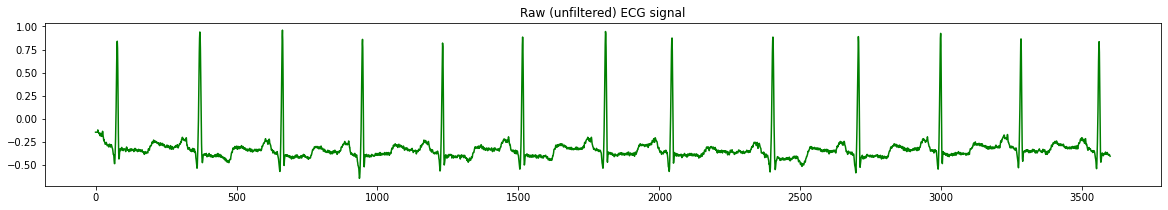

In [2]:
# Detection of QRS complex peaks using pan tompking algorithm, ploting results of each stage.
# Packages and library used. 
import wfdb
from wfdb import processing
import numpy as np
import pandas as pd
import scipy.signal as signal
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
import neurokit2 as nk


#sets the backend of matplotlib to the 'inline' backend With this backend, the output of plotting commands is                                 displayed inline within frontends like the Jupyter notebook, directly below the code cell that produced it.
%matplotlib inline      
plt.rcParams['figure.figsize'] = [20, 3] #used to plot the figures
sig, fields = wfdb.rdsamp('mit-bih-arrhythmia-database-1.0.0/100',sampfrom=0, sampto=3600) # Read a WFDB record
unfiltered_signal = sig[:, 0]
plt.title("Raw (unfiltered) ECG signal")
plt.plot(unfiltered_signal, 'g')
plt.show()

Band bass filter: The signal must be filtered to obtain the band where they can find the QRS and eliminate other interfering signals. First a                   low pass filter is made that removes noise from highfrequency and then a high-pass filter that removes DC components and P                    waves and T. 

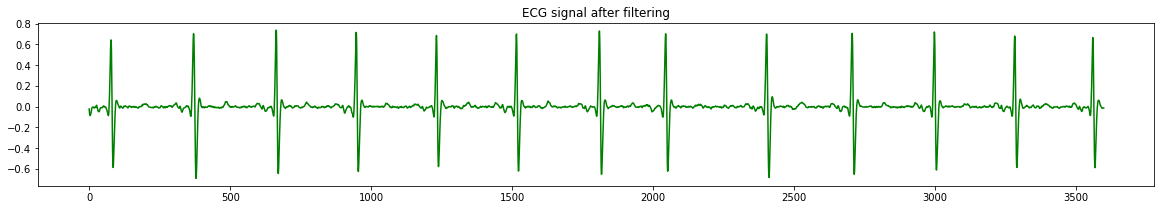

In [4]:
# Band pass filtering
fs = 360  #sampling frequency (All in samples)
nyquist_freq = 0.5 * fs
f1 = 5/nyquist_freq   #Lowpass
f2 = 15/nyquist_freq #Highpass
#The Butterworth filter is a type of signal processing filter designed to have as flat frequency response as possible (no ripples) in the pass-band 
b, a = signal.butter(1, [f1*2, f2*2], btype='bandpass') 
#The maximum delay, in samples, used in creating each output sample is called the order of the filter (using order 1)
filtered_ecg = signal.lfilter(b, a, unfiltered_signal)
plt.plot(filtered_ecg, 'g')
plt.title("ECG signal after filtering")
plt.show()

Differentiation is a standard technique for finding the high slopes that normally distinguish the QRS complexes from other ECG waves.
The derivative amplifies the higher frequencies characteristic of the QRS complex while attenuating the lower frequencies of the P and T
waves.

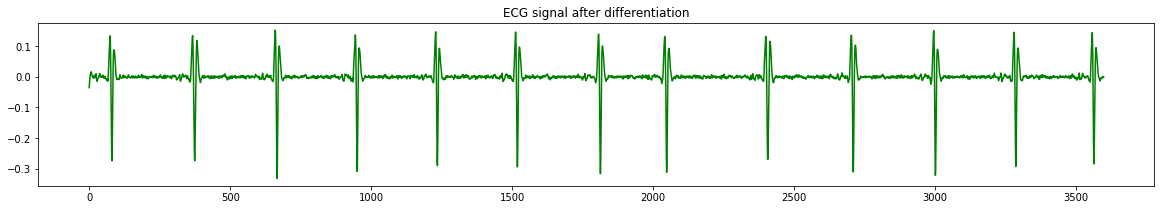

In [5]:
# Derivation (differentiation)
diff = np.diff(filtered_ecg) #Diff is a numpy function for differentiation.
plt.plot(diff, 'g')
plt.title("ECG signal after differentiation")
plt.show()

Squaring: is a nonlinear transformation that consists of point-by-point squaring of the signal samples. This transformation serves to make all the data positive prior to subsequent integration, and also accentuates the higher frequencies in the signal obtained from the differentiation process. These higher frequencies are normally characteristic of the QRS complex.

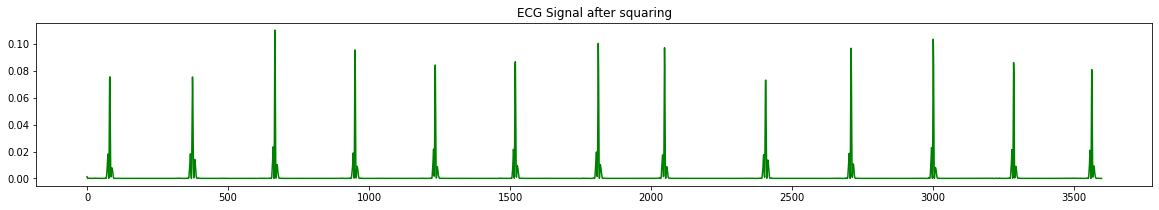

In [6]:
# Squaring
squared = diff*diff  #point to point squaring
plt.plot(squared, 'g')
plt.title("ECG Signal after squaring")
plt.show()

QRS Peak detection: After intergration of the signal through a moving window (the window’s width is choosen to be long enough to include the time duration of extended abnormal QRS complexes, but short enough so that it does not overlap both a QRS complex and a T wave.) to make preliminary detecion. After preliminary detection by the adaptive thresholds, decision processes make the final determination as to whether or
not a detected event was a QRS complex.

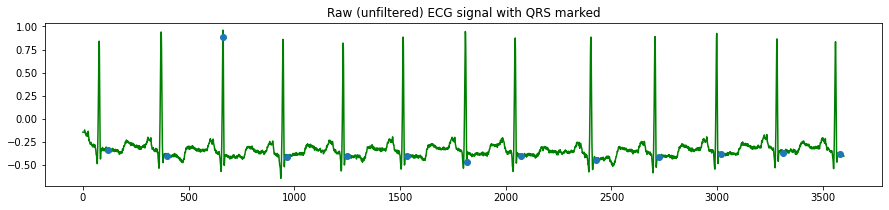

In [7]:
# Peak detection
from test import panPeakDetect, MWA_from_name  #MWA- moving window average
N = int(0.12*fs)
mwa = MWA_from_name("cumulative")(squared, N)
mwa[:int(0.2*fs)] = 0
mwa_peaks = panPeakDetect(mwa, fs)
plt.figure(figsize=(15,3))
plt.plot(unfiltered_signal,'g')
plt.plot(mwa_peaks,unfiltered_signal[mwa_peaks],"o")
plt.title("Raw (unfiltered) ECG signal with QRS marked")
plt.show()

STEP 2: Extraction of data point or characteristics that will be used to design the neural network which will be used to classify the beats.

We will be extracting 28 characteristics which includes:

1. Pre RR Interval,
2. Post RR Interval,
3. Mean Value of RR Interval,
4. Local Mean Value of RR Interval (10 close values),
5. QRS complex duration,
6. Boolean value indicating the presence of P wave,
7. Duration of ST interval, and
8. Heartbeat morphology: 21 samples.

In [8]:
#After detection of the QRS complexes we will be able to extract the necessary characteristics.
#Loading the data from the database and detecting the QRS complexes.
sig, fields = wfdb.rdsamp('mit-bih-arrhythmia-database-1.0.0/100', channels=[0])  #Using patient 102
xqrs = processing.XQRS(sig=sig[:,0], fs=fields['fs'])
xqrs.detect()

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.


In [9]:
# Calculating pre rr intervals.
import sys
import numpy as np
from wfdb import processing  #wfdb built in function 
pre_rr_interval = processing.calc_rr(xqrs.qrs_inds,fs=360)
np.set_printoptions(edgeitems=26)
print(pre_rr_interval)
#plt.plot(pre_rr_interval)


[294 292 284 285 284 294 235 358 303 292 285 277 303 308 295 299 296 286
 287 285 296 312 297 282 286 278 ... 275 282 284 281 261 260 255 258 261
 282 269 261 265 258 251 247 258 262 269 274 255 246 253 253 249 259]


In [11]:
# Calculating post rr intervals.
#Interpolation is a statistical method by which related known values are used to estimate an unknown value
from scipy.ndimage.interpolation import shift  #Shift an array.The array is shifted using spline interpolation of the requested order
post_rr_interval = shift(pre_rr_interval, -1, cval=np.NaN)
print(post_rr_interval)

[                 292                  284                  285
                  284                  294                  235
                  358                  303                  292
                  285                  277                  303
                  308                  295                  299
                  296                  286                  287
                  285                  296                  312
                  297                  282                  286
                  278                  284 ...                  282
                  284                  281                  261
                  260                  255                  258
                  261                  282                  269
                  261                  265                  258
                  251                  247                  258
                  262                  269                  274
                  255               

In [12]:
# Calculating Mean value of RR intervals.
#Python numpy.ones() function returns a new array of given shape and data type, where the element’s value is set to 1
rr_mean = np.ones(len(pre_rr_interval)) * pre_rr_interval.mean()  
print(rr_mean)

[286.05457746 286.05457746 286.05457746 286.05457746 286.05457746
 286.05457746 286.05457746 286.05457746 286.05457746 286.05457746
 286.05457746 286.05457746 286.05457746 286.05457746 286.05457746
 286.05457746 286.05457746 286.05457746 286.05457746 286.05457746
 286.05457746 286.05457746 286.05457746 286.05457746 286.05457746
 286.05457746 ... 286.05457746 286.05457746 286.05457746 286.05457746
 286.05457746 286.05457746 286.05457746 286.05457746 286.05457746
 286.05457746 286.05457746 286.05457746 286.05457746 286.05457746
 286.05457746 286.05457746 286.05457746 286.05457746 286.05457746
 286.05457746 286.05457746 286.05457746 286.05457746 286.05457746
 286.05457746 286.05457746]


In [14]:
#Detecting the presence of p wave.
#ecg_delineate(), Neurokit implements different methods to segment the QRS complexes. There are the derivative method and the other methods #that make use of Wavelet to delineate the complexes.
# Delineate the ECG signal
_, waves_peak = nk.ecg_delineate(sig[:,0], {"ECG_R_Peaks": xqrs.qrs_inds}, sampling_rate=360, method="dwt")

In [15]:
# Boolean value indicating the presence of P wave
p_peaks = waves_peak["ECG_P_Peaks"]
df = pd.DataFrame(p_peaks)
p_wave_presence = df.applymap(lambda x: 1 if x else  0) # converting to zeros and ones.
p_wave_presence = p_wave_presence.to_numpy()
p_wave_presence = p_wave_presence.reshape(1,-1)[0]
print(p_wave_presence)


[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [16]:
# QRS complex duration is the time between the start of the QRS complex and the end of the QRS complex
q_onsets = np.array(waves_peak["ECG_R_Onsets"])
q_offsets = np.array(waves_peak["ECG_R_Offsets"])
q_duration = q_offsets - q_onsets
q_duration_df = pd.DataFrame(q_duration)
print(q_duration_df)

         0
0      NaN
1     37.0
2     33.0
3     36.0
4     33.0
...    ...
2268  34.0
2269  34.0
2270  34.0
2271  33.0
2272   NaN

[2273 rows x 1 columns]


In [17]:
# Duration of ST interval is the sum of theduration of two fundamental components of a beat, the durationof the ST segment plus the duration # of the T wave
q_offsets = np.array(waves_peak["ECG_R_Offsets"]) 
t_offsets = np.array(waves_peak["ECG_T_Offsets"])
t_onsets = np.array(waves_peak["ECG_T_Onsets"])
st_segment  = t_offsets - q_offsets
twave_duration = t_offsets - t_onsets
st_interval = st_segment + twave_duration
df_st_interval = pd.DataFrame(st_interval)
print(df_st_interval)

          0
0       NaN
1     131.0
2     102.0
3     190.0
4      43.0
...     ...
2268   51.0
2269  146.0
2270   66.0
2271  143.0
2272    NaN

[2273 rows x 1 columns]


In [18]:
# This is the presentation of Dataset extracted from above methods all together.
dataset = pd.DataFrame(np.array([pre_rr_interval,post_rr_interval,rr_mean,st_interval,q_duration,p_wave_presence,resampled_signal]))
dataset

NameError: name 'resampled_signal' is not defined

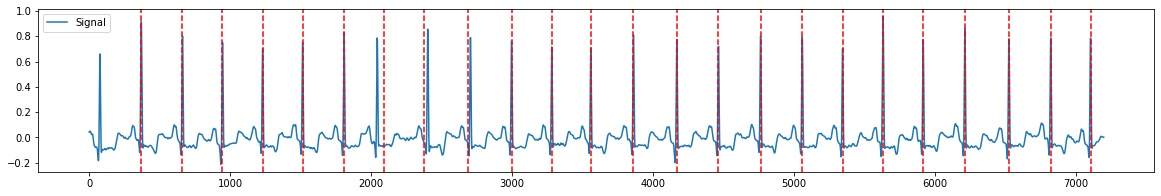

In [59]:
%matplotlib inline      
plt.rcParams['figure.figsize'] = [20, 3] #used to resize plotted figures
sig, fields = wfdb.rdsamp('mit-bih-arrhythmia-database-1.0.0/100',sampfrom=0, sampto=7200) # Read a WFDB record
ecg_signal = sig[:, 0]

# Automatically process the (raw) ECG signal
signals, info = nk.ecg_process(ecg_signal, sampling_rate=360)
# Extract clean ECG and R-peaks location
rpeaks = info["ECG_R_Peaks"]
cleaned_ecg = signals["ECG_Clean"]
# Visualize R-peaks in ECG signal
plot = nk.events_plot(rpeaks, cleaned_ecg)



In [60]:
# Plotting all the heart beats
epochs = nk.ecg_segment(cleaned_ecg, rpeaks=None,sampling_rate=360)

In [63]:
# Define a function to create epochs
def plot_heartbeats(cleaned, peaks, sampling_rate=None, show=True):
    heartbeats = nk.epochs_create(cleaned, events=peaks, epochs_start=-0.05, epochs_end=0.18, sampling_rate=sampling_rate)
    heartbeats = nk.epochs_to_df(heartbeats)
    return heartbeats
heartbeats = plot_heartbeats(cleaned_ecg, peaks=rpeaks, sampling_rate=360)
signal_bits = heartbeats['Signal']
new_signal = signal_bits.values.reshape(1,-1)
signal_for_resamble = new_signal[0]
print(signal_for_resamble)
heartbeats.head(4000)

[-0.04037867 -0.05214328 -0.06697031 -0.08465569 -0.10224022 -0.11533614
 -0.12016794 -0.11265399 -0.08667183 -0.03630309  0.04202367  0.14739007
  0.27551041  0.41954796  0.56991089  0.71027267  0.82308228  0.89395197
  0.91512664  0.8838512   0.80318687  0.6817051   0.5357324   0.38435042
  0.24419182  0.12495048 ... -0.04377595 -0.0413999  -0.0394144
 -0.03761519 -0.03661434 -0.03641167 -0.03659885 -0.03676754 -0.03661144
 -0.0364365  -0.03634457 -0.03633547 -0.03579678 -0.03493241 -0.03374215
 -0.03283809 -0.03181186 -0.03076532 -0.02939217 -0.0278963  -0.02637955
 -0.02484175 -0.02338473 -0.02200831 -0.02030413 -0.01816995]


,Signal,Index,Label,Time
0,-0.040379,352,1,-0.050000
1,-0.052143,353,1,-0.047160
2,-0.066970,354,1,-0.044321
3,-0.084656,355,1,-0.041481
4,-0.102240,356,1,-0.038642
...,...,...,...,...
1963,-0.024842,7165,24,0.168642
1964,-0.023385,7166,24,0.171481
1965,-0.022008,7167,24,0.174321
1966,-0.020304,7168,24,0.177160


[[-4.03786695e-02 -5.21432777e-02 -6.69703122e-02 -8.46556875e-02
  -1.02240216e-01 -1.15336139e-01 -1.20167943e-01 -1.12653990e-01
  -8.66718289e-02 -3.63030873e-02  4.20236671e-02  1.47390071e-01
   2.75510414e-01  4.19547965e-01  5.69910891e-01  7.10272667e-01
   8.23082276e-01  8.93951966e-01  9.15126640e-01  8.83851200e-01
   8.03186875e-01  6.81705097e-01  5.35732401e-01  3.84350424e-01
   2.44191823e-01  1.24950481e-01  3.29529313e-02 -3.01681676e-02
  -6.62495466e-02 -8.15156909e-02 -8.38237392e-02 -8.05206259e-02
  -7.46675710e-02 -6.89176313e-02 -6.42912106e-02 -6.15025902e-02
  -6.05517656e-02 -6.11326099e-02 -6.19185880e-02 -6.31137770e-02
  -6.45140908e-02 -6.61195249e-02 -6.84402788e-02 -7.04559398e-02
  -7.13501768e-02 -7.12250260e-02 -7.05906869e-02 -6.96512365e-02
  -6.89168744e-02 -6.76733101e-02 -6.67368656e-02 -6.64136587e-02
  -6.71118479e-02 -6.81171430e-02 -6.95315799e-02 -7.08449501e-02
  -7.18531670e-02 -7.25562261e-02 -7.34643266e-02 -7.44754232e-02
  -7.57935

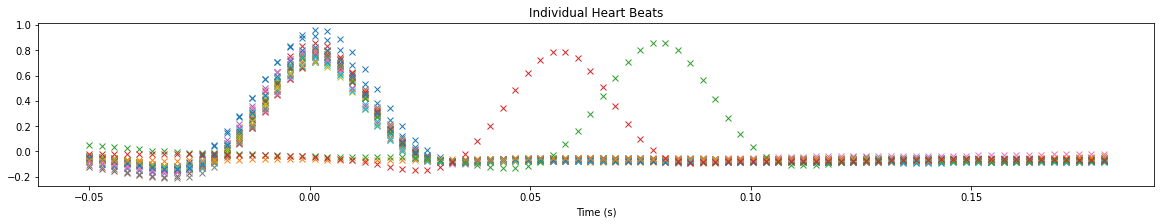

In [62]:
heartbeats_pivoted = heartbeats.pivot(index='Time', columns='Label', values='Signal')
heartbeats_plot = heartbeats
heartbeats_pivoted1 = heartbeats_plot.pivot(index="Label", columns="Time", values="Signal")
# new_signal = signal_bits.values.reshape(1,-1)
# signal_for_resamble = new_signal[0]
# print(signal_for_resamble)
plt.plot(heartbeats_pivoted,"x")
plt.xlabel("Time (s)")
plt.title("Individual Heart Beats")
heartbeats_pivoted1.head(4000)
data_to_resample = []
for bit in heartbeats_pivoted1.values:
    data_to_resample.append(bit)
resampled_data = []
for bit in data_to_resample:
    resampled_data.append(np.array(wfdb.processing.resample_sig(x=bit, fs=fields['fs'], fs_target=360)))
for data in resampled_data:
    print(data)


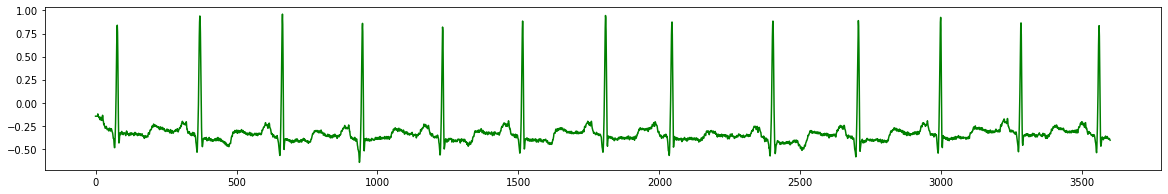

[-0.145 -0.145 -0.145 -0.145 -0.145 -0.145 -0.145 -0.145 -0.12  -0.135
 -0.145 -0.15  -0.16  -0.155 -0.16  -0.175 -0.18  -0.185 -0.17  -0.155
 -0.175 -0.18  -0.19  -0.18  -0.155 -0.135 ... -0.39  -0.4   -0.38  -0.385
 -0.385 -0.385 -0.385 -0.37  -0.37  -0.36  -0.38  -0.38  -0.385 -0.37
 -0.37  -0.365 -0.375 -0.385 -0.39  -0.39  -0.385 -0.385 -0.395 -0.39
 -0.4   -0.405]


In [23]:
sig, fields = wfdb.rdsamp('mit-bih-arrhythmia-database-1.0.0/100',sampfrom=0, sampto=3600)
unresampled_signal = np.array(sig[:, 0])
plt.plot(unresampled_signal, 'g')
plt.show()
#np.set_printoptions(threshold=sys.maxsize)
#np.set_printoptions(edgeitems=200)
print (unresampled_signal)

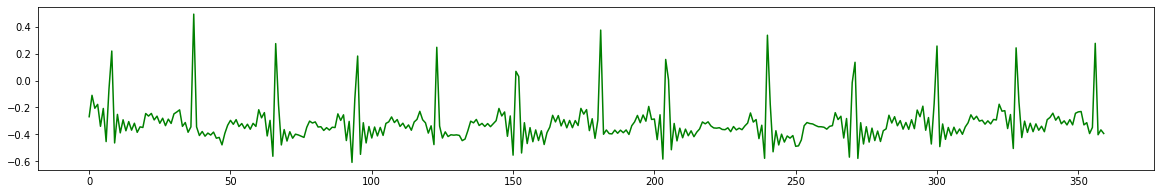

[-0.26920366 -0.10970725 -0.20618681 -0.1772679  -0.34073662 -0.20763722
 -0.4545058  -0.06518068  0.2202747  -0.46466556 -0.25193161 -0.38959983
 -0.2920878  -0.37402488 -0.30559951 -0.36926817 -0.31782565 -0.38558635
 -0.34486526 -0.3494579  -0.2452489  -0.26442127 -0.24475693 -0.29311042
 -0.26487026 -0.31816281 -0.28058021 -0.33583699 -0.28720728 -0.31919677
 -0.24811103 -0.23405579 -0.217985   -0.34108892 -0.31266438 -0.38503036
 -0.34488748  0.49529447 -0.34490545 -0.40919502 -0.37940828 -0.41427586
 -0.39122013 -0.40582751 -0.38389387 -0.42955927 -0.42342831 -0.4789704
 -0.39376431 -0.33285734 -0.29634134 -0.32584896 -0.29110251 -0.34254632
 -0.32006506 -0.35710956 -0.325063   -0.36246093 -0.31867753 -0.34135927
 -0.21719588 -0.27767627 -0.23853876 -0.41246325 -0.29640564 -0.56407142
  0.2756806  -0.18032431 -0.47950754 -0.36507129 -0.45044901 -0.38132237
 -0.42962836 -0.39936455 -0.40507786 -0.41469169 -0.42342827 -0.34763551
 -0.30189657 -0.31626681 -0.30777463 -0.34595884 -0.

In [24]:
x, _ = wfdb.processing.resample_sig(x=unresampled_signal, fs=fields['fs'], fs_target=36)
resampled_signal = np.array(x)
plt.plot(resampled_signal, 'g')
plt.show()
#np.set_printoptions(threshold=sys.maxsize)
print (resampled_signal)